## Stacking vs Mixtura de Modelos

Se toman los datos de kaggle siguientes: https://www.kaggle.com/datasets/thedevastator/analyzing-credit-card-spending-habits-in-india y se pretende realizar una comparativa sencilla entre las ventajas y desventajas de hacer uso de un Stacking frente a una Mixtura de modelos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  roc_auc_score

Paso 1: Se traen y se miran brevemente los datos a utilizar, al no haber muchos en este ejemplo, se hace uso de pandas directamente:

In [2]:
df = pd.read_csv('data/IndianCreditCard.csv')

In [3]:
df.head()

,index,City,Date,Card Type,Exp Type,Gender,Amount
0,0,"Delhi, India",29-Oct-14,Gold,Bills,F,82475
1,1,"Greater Mumbai, India",22-Aug-14,Platinum,Bills,F,32555
2,2,"Bengaluru, India",27-Aug-14,Silver,Bills,F,101738
3,3,"Greater Mumbai, India",12-Apr-14,Signature,Bills,F,123424
4,4,"Bengaluru, India",5-May-15,Gold,Bills,F,171574


In [4]:
df.shape

(26052, 7)

Paso 2: Se va a crear una "target" artificial a predecir que va a ser Amount anormalmente bajos, para ello se va a realizar un histograma de la variable Amount y se va a elegir, por inspección directa dicho valor. Hay modos más avanzados de hacerlo como tomar el primer cuartil o un percentil del 5% u otro. Se deja al interesado que pruebe estas otras modalidades y siga el razonamiento posterior.

En este caso se observa que una cantidad adecuada sería menos de 5.000

<AxesSubplot:xlabel='Amount', ylabel='Density'>

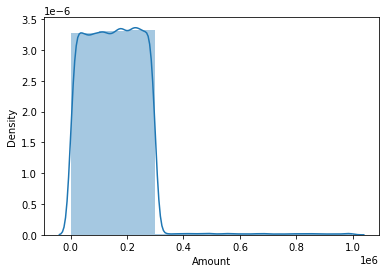

In [5]:
sns.distplot(df['Amount'], bins=10)

In [6]:
df['target'] = np.where(df['Amount'] <= 5000, 1, 0)

In [7]:
np.mean(df['target'])

0.014125594963918317

In [8]:
np.sum(df['target'])

368

Algo más un 1.4% de los datos cumplen con esa propiedad

Paso 3: Feature Engineering, se convierten variables texto a numéricas. Necesario para poder construir los modelos, python necesita variables numéricas

In [9]:
pd.unique(df['City']) #Esta variable no se trabajará ya que llevaría demasiado tiempo y es necesario agrupar teniendo
                        #en cuenta conocimiento de la zona, por lo que sólo se considerará la capital 'Delhi, India', 
                        #frente al resto

array(['Delhi, India', 'Greater Mumbai, India', 'Bengaluru, India',
       'Ahmedabad, India', 'Markapur, India', 'Mavoor, India',
       'Sillod, India', 'Nainital, India', 'Laharpur, India',
       'Shenkottai, India', 'Neyveli (TS), India', 'Kapadvanj, India',
       'Arambagh, India', 'Thana Bhawan, India', 'Kancheepuram, India',
       'Sojat, India', 'Karjat, India', 'Mohali, India',
       'Narayanpet, India', 'Bhavnagar, India', 'Viluppuram, India',
       'Jamalpur, India', 'Udaipurwati, India', 'Palanpur, India',
       'Muzaffarpur, India', 'Taranagar, India', 'Ambikapur, India',
       'Mundi, India', 'Padrauna, India', 'Vijayapura, India',
       'Vrindavan, India', 'Byasanagar, India', 'Mudhol, India',
       'Sohna, India', 'Pune, India', 'Lakheri, India',
       'Jehanabad, India', 'Shegaon, India',
       'Shikarpur Bulandshahr, India', 'Dalli-Rajhara, India',
       'Mapusa, India', 'Uthamapalayam, India', 'Nasirabad, India',
       'Kapurthala, India', 'Anand, India'

In [10]:
df['Delhi'] = np.where(df['City'] == 'Delhi, India', 1, 0)

In [11]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month

In [12]:
pd.unique(df['Card Type'])

array(['Gold', 'Platinum', 'Silver', 'Signature'], dtype=object)

In [13]:
df['Gold'] = np.where(df['Card Type'] == 'Gold', 1, 0)
df['Platinum'] = np.where(df['Card Type'] == 'Platinum', 1, 0)
df['Silver'] = np.where(df['Card Type'] == 'Silver', 1, 0)

In [14]:
pd.unique(df['Exp Type'])

array(['Bills', 'Food', 'Entertainment', 'Grocery', 'Fuel', 'Travel'],
      dtype=object)

In [15]:
df['Bills'] = np.where(df['Card Type'] == 'Bills', 1, 0)
df['Food'] = np.where(df['Card Type'] == 'Food', 1, 0)
df['Entertainment'] = np.where(df['Card Type'] == 'Entertainment', 1, 0)
df['Grocery'] = np.where(df['Card Type'] == 'Grocery', 1, 0)
df['Fuel'] = np.where(df['Card Type'] == 'Fuel', 1, 0)

In [16]:
pd.unique(df['Gender'])

array(['F', 'M'], dtype=object)

In [17]:
df['Female'] = np.where(df['Gender'] == 'F', 1, 0)

In [18]:
df_analytic = df[['Delhi', 
                  'Month',
                  'Gold', 'Platinum', 'Silver', 
                  'Bills', 'Food', 'Entertainment', 'Grocery', 'Fuel', 
                  'Female', 
                  'target']]

Paso 4: Se separa los conjuntos en 2 mitades al 70% y 30% ponderando por la target, para las comprobaciones posteriores sobre una misma muestra de validación

In [19]:
X = df_analytic.drop('target', axis=1)
y = df_analytic['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Paso 5_1: Se crea un modelo de regresión logística con la información del tipo de tarjeta sólamente. Se obtiene una predictividad muy baja, pero para lo que se quiere ilustrar puede valer

In [20]:
X_train1 = X_train[['Gold', 'Platinum', 'Silver', 
                    'Bills', 'Food', 'Entertainment', 'Grocery', 'Fuel']]
X_test1 = X_test[['Gold', 'Platinum', 'Silver', 
                  'Bills', 'Food', 'Entertainment', 'Grocery', 'Fuel']]

In [21]:
model1 = LogisticRegression()
model1.fit(X_train1, y_train)

y_prob1 = model1.predict_proba(X_test1)[:, 1]

auc = roc_auc_score(y_test, y_prob1)
print("AUC: {:.2f}".format(auc))

AUC: 0.52


Paso 5_2: Se crea un modelo de regresión logísta con el resto de la información no utilizada

In [22]:
X_train2 = X_train[['Delhi',
                    'Month',
                    'Female']]
X_test2 = X_test[['Delhi',
                    'Month',
                    'Female']]

In [23]:
model2 = LogisticRegression()
model2.fit(X_train1, y_train)

y_prob2 = model2.predict_proba(X_test1)[:, 1]

auc = roc_auc_score(y_test, y_prob2)
print("AUC: {:.2f}".format(auc))

AUC: 0.52


Supongamos que como banco disponemos del Modelo 2 y un proveedor externo nos quiere vender las virtudes del modelo que ha creado (Modelo 1). Nosotros hemos aceptado comprar el modelo pero tenemos que integrarlo a nuestra información. En ningún caso el proveedor nos dirá ¿Cuáles son las variables que integra su modelo?, ya que podríamos usarlas nosotros mismos y prescindir de dicho proveedor.

#### Opción habitual stacking de Modelos bajo una Regresión Logística

En este caso el proveedor nos proporcionaría algo similar a una variable que proviene de realizar previsiones en el modelo. En este ejemplo, se va suponer que esa variable se crea prediciendo sobre el mismo training con el que se ha entrenado la muestra, lo cual nunca va a suceder y por tanto aquí se estaría ante una posición muy optimista con respecto a lo que sucedería en la realidad, cuyos resultados deberían ser notoriamente más pobres.

Así pues frente al modelo 2:

    (1) Se integra una nueva variable que es el resultado de la previsión del modelo 1 sobre el training (y también sobre el test)
    (2) Se estima un modeloStk con dicha variable extra
    (3) Se observa qué sucede en el test (considerando que en el test se tendrá también dicha variable extra)

In [24]:
X_trainStk = X_train2
X_testStk = X_test2

X_trainStk['VarProvider'] = model1.predict_proba(X_train1)[:, 1]
X_testStk['VarProvider'] = model1.predict_proba(X_test1)[:, 1]

modelStk = LogisticRegression()
modelStk.fit(X_trainStk, y_train)

y_probStk = modelStk.predict_proba(X_testStk)[:, 1]

auc = roc_auc_score(y_test, y_probStk)
print("AUC: {:.2f}".format(auc))

AUC: 0.50


#### Opción mixtura de modelos

En este caso, el cliente tiene su propio modelo y el proveedor el suyo. No hay que re-estimar parámetros combinando ambos modelos, sólo se necesita las predicciones de ambos modelos y mezclarlas bajo un porcentaje que no tiene que ser el 50% - 50% y que puede optimizarse en la práctica.

El resultado siguiente si suele ser más realista y como se ve, su construcción y puesta en producción final es más sencilla y requiere menos código.

En este caso el resultado al menos no empeora. En aplicaciones en real se observa que incluso mejora (la experiencia en Kaggle así parece afirmarlo y también en la práctica).

In [25]:
y_probMix = 0.5 * y_prob1 + 0.5 * y_prob2

auc = roc_auc_score(y_test, y_probMix)
print("AUC: {:.2f}".format(auc))

AUC: 0.52
